# Analyses Total GHG Emissions

## pipepline

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor   
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import kernel_ridge
from sklearn import preprocessing
import shap

#####################################
##### Call a function
#####################################
import builtins
def do_call(what, *args, **kwargs):
    return getattr(builtins, what)(*args, **kwargs)

do_call('sum', range(1, 11))
#####################################
##### K-fold
#####################################
def Folds(X, y, n_splits):        
    kf  = KFold(n_splits=n_splits)
    kf.get_n_splits(X)
    XfoldsTrain = []
    XfoldsTest= []
    yfoldsTrain = []
    yfoldsTest= []
    for train_index, test_index in kf.split(X):
        XfoldsTrain.append(X[X.index.isin(train_index)])
        XfoldsTest.append(X[X.index.isin(test_index)])
        
        yfoldsTrain.append(y[y.index.isin(train_index)])
        yfoldsTest.append(y[y.index.isin(test_index)])
                
    return XfoldsTrain, XfoldsTest, yfoldsTrain, yfoldsTest

#####################################
##### K-fold
#####################################
def SFolds(X, y, n_splits):  # y need to be categorical  
    skf = StratifiedKFold(n_splits=3)
    XfoldsTrain = []
    XfoldsTest= []
    yfoldsTrain = []
    yfoldsTest= []
    
    for train_index, test_index in skf.split(X, y):
        XfoldsTrain.append(X[X.index.isin(train_index)])
        XfoldsTest.append(X[X.index.isin(test_index)])
        
        yfoldsTrain.append(y[y.index.isin(train_index)])
        yfoldsTest.append(y[y.index.isin(test_index)])

    return XfoldsTrain, XfoldsTest, yfoldsTrain, yfoldsTest

#####################################
##### Model selection, best hyperparameters, with folding
#####################################
def mlPippline(pipelines, hypergrid, X_train, y_train, X_test, y_test, cv=10, n_jobs = -1, progress = True, metric = "r2"):
    # Scale
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test = std_scale.transform(X_test)
    
    # Selection des meileurs hyperparametres
    fit_models = {}
    for algo, pipeline in pipelines.items():
        model = GridSearchCV(pipeline, hypergrid[algo], cv=cv, n_jobs=n_jobs, refit = True, scoring = metric)        
        try:
            model.fit(X_train, y_train)            
            fit_models[algo] = model
            if progress:            
                # Afficher les performances correspondantes
                print("Résultats de la validation croisée pour " + algo + ":")
                for mean, std, params in zip(
                        model.cv_results_['mean_test_score'], # score moyen
                        model.cv_results_['std_test_score'],  # écart-type du score
                        model.cv_results_['params']           # valeur de l'hyperparamètre
                    ):

                    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
                        "r2",
                        mean,
                        std*2,
                        params
                    ) )            
        except NotFittedError as e:
            print(repr(e))
    
    # Selection du meilleure modèle
    synthesis = []    
    #X_test = std_scale.transform(X_test)
    for algo,model in fit_models.items():        
        #yhat = model.predict(X_test)        
        #synthesis.append([r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)])
        synthesis.append(model.best_score_)
    synthesis = pd.DataFrame(synthesis)
    synthesis.index = fit_models.items()
    synthesis.columns = [metric]
    
    return fit_models, synthesis, std_scale

#####################################
##### ML
#####################################
def ML(pipelines, hypergrid, X,y, test_size=0.20, random_state=1234, cv=10, n_jobs = -1, progress = True, yTrasnfrom = "log"):
    #split    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state) 
    
    if "log" in yTrasnfrom:
        y_train = np.log10(1+y_train)
        y_test = np.log10(1+y_test)
        
    # test models
    result, synthesis, std_scale = mlPippline(pipelines, hypergrid, X_train, y_train, X_test, y_test, cv=10, n_jobs = -1, progress = progress)
    
    return result, synthesis , std_scale, X_train, y_train, X_test, y_test

#####################################
##### Test baseline model
#####################################
def baselineModel(X_train, y_train, X_test, y_test, strategy = "mean"):
    baseline = DummyRegressor(strategy= strategy)
    baseline.fit(X_train, y_train)
    print(baseline.score(X_test, y_test))    
    return baseline

#####################################
##### Plot model predictions versus real data
#####################################
def predictionVdata(m, X_test, y_test):
       predictions = m.predict(X_test)
       plt.scatter( y_test, predictions)
       plt.xlabel("model predictions")
       plt.ylabel("original values")
       plt.show()

#####################################
##### Features importance
#####################################
def modelDiagnostic(m, X_test, threshold):
    UslessVariables =  X_test.columns[np.where(m.best_estimator_.feature_importances_ == 0)]
    UsfullVariables =  X_test.columns[np.where(m.best_estimator_.feature_importances_ > 0)]

    mdi_importances = pd.Series(
    m.best_estimator_.feature_importances_, index=X_test.columns
    ).sort_values(ascending=False)
    mdi_importances[mdi_importances > threshold ].plot.bar()
    return mdi_importances, UslessVariables, UsfullVariables

#####################################
##### Model Visualization
#####################################

def modelVisualization(m, X_test, Y_test, select = range(20), nBestValues = 10):
    if str(m.estimator) == "GradientBoostingRegressor()" or str(m.estimator) == "RandomForestRegressor()":
        explainer = shap.TreeExplainer(m.best_estimator_)
        
        #P1
        import warnings
        expected_value = explainer.expected_value
        if isinstance(expected_value, list):
            expected_value = expected_value
        print(f"Explainer expected value: {expected_value}")
        
        features = X_test.iloc[select]
        features_display = X_test.loc[features.index]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            shap_values = explainer.shap_values(features)[1]
            shap_interaction_values = explainer.shap_interaction_values(features)
        if isinstance(shap_interaction_values, list):
            shap_interaction_values = shap_interaction_values[1]
        shap.decision_plot(expected_value, shap_values, features_display)
        
        #P2
        mdi_importances = pd.Series(
        m.best_estimator_.feature_importances_, index=X_test.columns
        ).sort_values(ascending=True)
        mdi_importances = mdi_importances.iloc[-nBestValues:,]
        ax = mdi_importances.plot.barh()
        ax.set_title("Random Forest Feature Importances (MDI)")
        ax.figure.tight_layout()
        
        ## P3
        #shap_values = explainer.shap_values(X_test)
        #shap.initjs()
        #shap.force_plot(explainer.expected_value, shap_values, X_test, feature_names=X_train.columns)
        

Etant donnée le problème demandant la prédiction d'une variable continue on utilisera que les méthodes de regression.

## Modèles

In [2]:
pipelines = {
    'rf':RandomForestRegressor(),
    'gb':GradientBoostingRegressor(),
    'ridge':Ridge(),
    'lasso':Lasso(),
    'enet':ElasticNet(),
    'kernelRidge':  kernel_ridge.KernelRidge()
}
hypergrid = {
    'rf': {
        'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
        'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    },
    'gb':{
        "learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99], # Vitesse de correction de l'érreur 
        'n_estimators' : [10,50,100,300,500] # #nombre d'arbres de décision
    },
    'ridge':{
        'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99] # Poids de correction de l'érreur 
    },
    'lasso':{
        'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99] # Poids de correction de l'érreur 
    },
    'enet':{
        'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]# Poids de correction de l'érreur 
    },
    'kernelRidge':{
        'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99], # Poids de correction de l'érreur 
        'kernel':['rbf'],# Noyau utilisé
    }
}

### Import des données

In [3]:
import pickle
input1 = open("X.pickle", "rb")
X = pickle.load(input1)
input1.close()

input1 = open("Ys.pickle", "rb")
Ys = pickle.load(input1)
input1.close()


### Sans log

In [4]:
y = Ys.iloc[:,1]
models, synthesis , std_scale, X_train, y_train, X_test, y_test= ML(pipelines, hypergrid, X, y, test_size=0.20, random_state=1234, cv=10, n_jobs = -1, progress = False, yTrasnfrom="no")
synthesis

,,r2
rf,"GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,\n param_grid={'min_samples_leaf': [1, 3, 5, 10],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.340003
gb,"GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,\n param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,\n 0.99],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.223883
ridge,"GridSearchCV(cv=10, estimator=Ridge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.172074
lasso,"GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.176959
enet,"GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.259876
kernelRidge,"GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99],\n 'kernel': ['rbf']},\n scoring='r2')",0.397365


0.9073399294635158


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.229e+05, tolerance: 3.435e+04


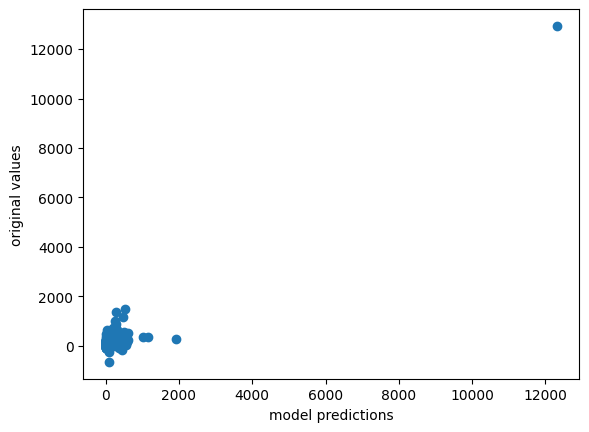

In [5]:
m1 = models["lasso"]
m1.fit(X_train, y_train)
print(m1.score(X_test, y_test))
predictionVdata(m1, X_test, y_test)

### Avec log

In [6]:
y = Ys.iloc[:,1]
models, synthesis , std_scale, X_train, y_train, X_test, y_test= ML(pipelines, hypergrid, X, y, test_size=0.20, random_state=1234, cv=10, n_jobs = -1, progress = False)
synthesis

,,r2
rf,"GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,\n param_grid={'min_samples_leaf': [1, 3, 5, 10],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.503084
gb,"GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,\n param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,\n 0.99],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.514121
ridge,"GridSearchCV(cv=10, estimator=Ridge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.367355
lasso,"GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.375475
enet,"GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.375781
kernelRidge,"GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99],\n 'kernel': ['rbf']},\n scoring='r2')",0.247673


0.4914374950061423


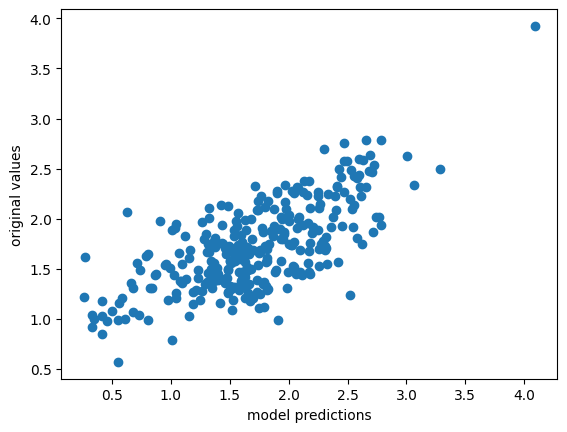

In [7]:
m1 = models["gb"]
m1.fit(X_train, y_train)
print(m1.score(X_test, y_test))
predictionVdata(m1, X_test, y_test)

### Avec log sans Energy score

In [8]:
y = Ys.iloc[:,1]
models, synthesis , std_scale, X_train, y_train, X_test, y_test= ML(pipelines, hypergrid, X.drop("ENERGYSTARScore", axis = 1), y, test_size=0.20, random_state=1234, cv=10, n_jobs = -1, progress = False)
synthesis

,,r2
rf,"GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,\n param_grid={'min_samples_leaf': [1, 3, 5, 10],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.469723
gb,"GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,\n param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,\n 0.99],\n 'n_estimators': [10, 50, 100, 300, 500]},\n scoring='r2')",0.475615
ridge,"GridSearchCV(cv=10, estimator=Ridge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.337730
lasso,"GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.349183
enet,"GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]},\n scoring='r2')",0.349387
kernelRidge,"GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,\n param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99],\n 'kernel': ['rbf']},\n scoring='r2')",0.205966


0.43068475518793015


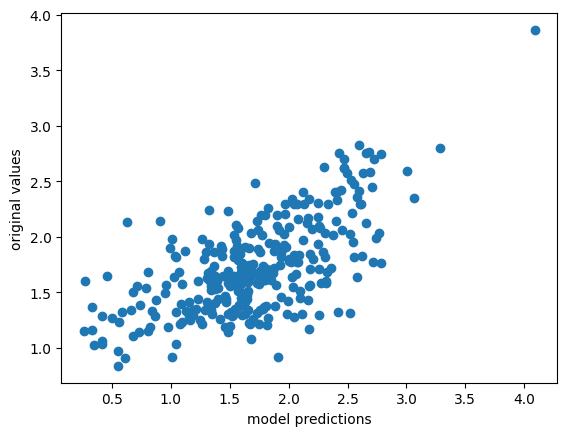

In [9]:
m1 = models["gb"]
m1.fit(X_train, y_train)
print(m1.score(X_test, y_test))
predictionVdata(m1, X_test, y_test)

Perte de 2% d'explication de la variance

#### Visualisation du modèle

Explainer expected value: [1.72211368]


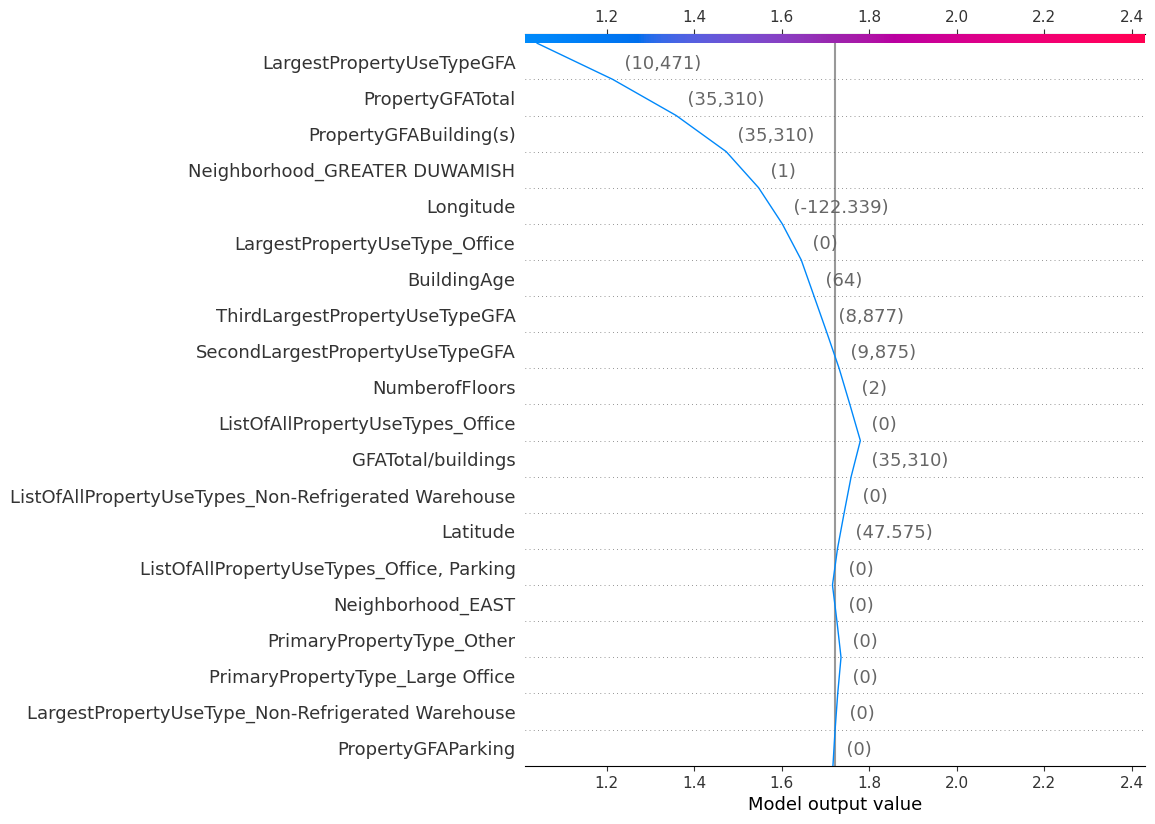

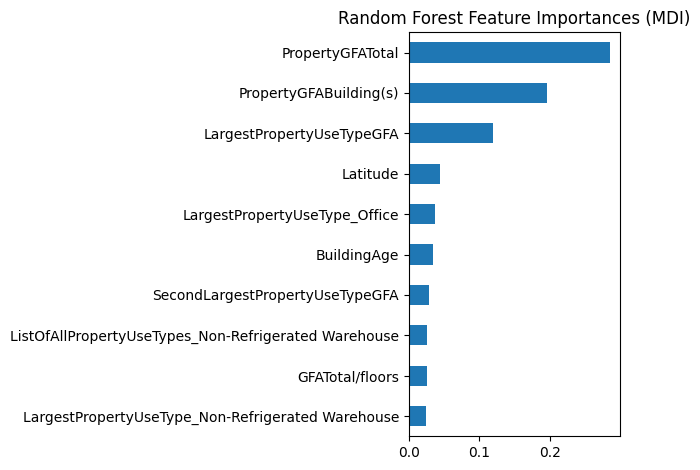

In [10]:
modelVisualization(m1, X_test, y_test)

## Comparaison avec un modèle de base

In [11]:
baselineModel(X_train, y_train, X_test, y_test, strategy = "mean")

-0.0005090247372614431


DummyRegressor()

## Sauvegarde du modèle

In [12]:
import pickle
model = open("model1.pickle", "wb")
pickle.dump(m1, model)
model.close()
scale = open("scale1.pickle", "wb")
pickle.dump(std_scale, scale)
scale.close()

# Plot non disponible dans la fonction

In [13]:
# P3
explainer = shap.TreeExplainer(m1.best_estimator_)
shap_values = explainer.shap_values(y_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, y_test, feature_names=X_train.columns)

In [14]:
explainer = shap.TreeExplainer(m1.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train, feature_names=X_train.columns)

# Fonction pour le réutiliser le modèle

In [15]:
from sklearn.impute import KNNImputer
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor   
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import kernel_ridge
from sklearn import preprocessing
import shap

def get_dummies_withThershold (df, column, thershold = 0.05):
    if df[column].dtype == "O": # If column is of object type
        series = catFr(df, column) # compute categories frequencies
        series = series[series > thershold].index # find categories frequencies greater than the thershold
        if(len(series) > 0):
            if len(series) == 1:
                print(" In " + column + "Only one categorie")
                return "NA"
            else:  
                df[column] = np.where(~df[column].isin(series.tolist()), "NA",df[column] ) # replace lower categories by NA
                tmp = pd.get_dummies(df[column]) # get dummies
                if "NA" in tmp.columns:
                    tmp.drop("NA", axis = 1, inplace=True) # drop NA
                tmp.columns = column + "_" + tmp.columns
                return tmp # return dummies  
        else:
            print(" In " + column + "all categories are bellow the thershold")
            return "NA"
    else:
        print(column + " in df is not an object type" )
    
def OHEfr_single(df, column, thershold = 0.05):
    """_summary_ 
        Remove a pandas column categories based on a given thershold
    Args:
        df (_type_): a panda data frame
        column (_type_): column name to work on
        thershold (float, optional): _description_. Defaults to 0.05.

    Returns:
        _type_: list of categories that are greateter than the thershold
    """
    if df[column].dtype == "O": # If column is of object type
        tmp = get_dummies_withThershold(df, column, thershold =thershold) # get dummies based on frequencies
        if "NA" in tmp:# If all categories are bellow the thershold return df without the column in question
            df.drop(column, axis = 1, inplace= True)
            return df 
        else:
            tmp = pd.concat([df, tmp], axis= 1) # merge with df
            tmp.drop(column, axis = 1, inplace= True) # drop columns on which dummies based on frequencies have been made
            return tmp
    else:
        return df #  # If column is not of object type return original data frame (to allow iteration on data frame)
        
def OHEfr(df, thershold = 0.05):
    for columns in df:
        df = OHEfr_single(df, columns, thershold= thershold)
    return df

def main(X, m1 = False, thershold = 0.05):
    # load model and scale
    if m1 == True:
        input1 = open("model1.pickle", "rb")
        m = pickle.load(input1)
        input1.close()
        input1 = open("scale1.pickle", "rb")
        scale = pickle.load(input1)
        input1.close()
    else:
        input1 = open("model.pickle", "rb")
        m = pickle.load(input1)
        input1.close()
        input1 = open("scale.pickle", "rb")
        scale = pickle.load(input1)
        input1.close()
    
    # Load KNN
    input1 = open("knnIlputer.pickle", "rb")
    imputer = pickle.load(input1)
    input1.close()
    
    # OHE
    X = OHEfr(X, thershold)
    
    # KNN
    col =  X.columns
    X_train = pd.DataFrame(imputer.fit_transform(X))
    X.columns =  col
    
    # Log    
    y_train = np.log10(1+y_train)
    y_test = np.log10(1+y_test)
    
    # Scale
    X = scale.transform(X)

    
    return(m.predict(X))
    

    